In [1]:
%run Settings.py
%run FunctionsODIASP.py

Les fonctions ont été importées


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import scipy
from scipy.ndimage import zoom, center_of_mass
import matplotlib.pyplot as plt
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import os
import pandas
from PIL import Image
import random
from shutil import copy2, move
from copy import copy
import skimage.io as io
import skimage.transform as trans
from alive_progress import alive_bar
import datetime
import scipy
import openpyxl
import time



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K


from Settings import COMPUTE_CAPACITY

def ApplyWindowLevel (Global_Level,Global_Window,image):
    """
    Utilisée dans FindL3
    Les valeurs des voxels en DICOM sont entre -2000 et +4000, pour afficher une image en echelle de gris (255 possibilités de gris sur un oridnateur classique) il faut réduire les 6000 possibilités à 255. Cette fonction est nécessaire avant d'afficher une image mais fait perdre des données (passage de 16 bits à  8 bits par pixel).
    Obligatoire pour sauvegarder une image png ou jpg mais fait perdre de l'information !
    
    On redéfinit les valeurs des pixels selon une largeur de fenetre et un centre

    Parameters
    ----------
        - Global_Level : centre de la fenetre (en UH)
        - Global_Window : largeur de la fenetre (en UH)
        - image : image ou volume numpy chargé en mémoire
        
    Returns
    -------
        - image_ret : l'image ou le volume après réglage du contraste.
    
    Notes
    -----
    Ne fonctionne PAS si l'image a déjà été normalisée. Dans ce cas utiliser WL_scaled en fournissant a et b (obtenu par la fonction normalize).
    
    """
    li=Global_Level-(Global_Window/2);
    ls=Global_Level+(Global_Window/2);
    image_ret=np.clip(image, li, ls)
    image_ret=image_ret-li
    image_ret=image_ret/(ls-li)
    image_ret=image_ret*255
    return image_ret

In [3]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

print("\nChargement des différents réseaux ODIASP")

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with strategy.scope():
    modelMUSCLE = tf.keras.models.load_model(r"C:\Users\alexa\IA\ODIASP\models_ODIASP\modelMUSCLE", compile=False) #get_unet_512_V4_30ep
    modelMUSCLE.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coef])



Chargement des différents réseaux ODIASP
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/rep

In [4]:
def segmlarge(path,nbcoupe,centre, Model_segmentation_muscles):
    WINDOW_CENTER = 40
    WINDOW_WIDTH = 400
    centre = float(centre)
    
    inter = {} 
    list_files = os.listdir(path)
    for f in list_files:
        if not os.path.isdir(f):
            f_long = os.path.join(path, f)
            _ds_ = pydicom.dcmread(f_long,specific_tags =["ImagePositionPatient","SliceThickness"])
            inter[f_long]=_ds_.ImagePositionPatient[2]
    inter_sorted=sorted(inter.items(), key=lambda x: x[1], reverse=True) 
    liste_fichiers=[x[0] for x in inter_sorted]
    
    if centre <nbcoupe :
        intervalledebut = centre
    else : intervalledebut = nbcoupe
        
    if centre +nbcoupe >len(liste_fichiers):
        intervallefin = len(liste_fichiers) - centre
    else : intervallefin = nbcoupe

    liste_a_calculer=liste_fichiers[int(centre):int(centre+intervallefin)]
    volume_numpy=np.zeros((len(liste_a_calculer),512,512))
    
    for k in range(0,len(liste_a_calculer)):
        dicom_file = pydicom.dcmread(liste_a_calculer[k], force=True)
        dicom_file.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        img_orig_dcm = (dicom_file.pixel_array)
        slope=float(dicom_file[0x28,0x1053].value)
        intercept=float(dicom_file[0x28,0x1052].value)
        img_modif_dcm=(img_orig_dcm*slope) + intercept
        volume_numpy[k,:,:]=img_modif_dcm
        pixelspace =float(str(dicom_file[0x28,0x0030].value)[1:7])
        epaisseur = float(dicom_file[0x18,0x0050].value)
    
    #volume_numpy = np.asarray(volume_numpy, dtype=np.float32)
    
    volume_wl=np.zeros((len(liste_a_calculer),512,512))
    for k in range (0,len(liste_a_calculer)):
        volume_wl[k,:,:]=ApplyWindowLevel(WINDOW_CENTER,WINDOW_WIDTH,volume_numpy[k,:,:])
    volume_to_predict = volume_wl[:,:,:,np.newaxis]        
    
    #Creation d'un masque pour ne garder que les pixels entre -29 et 150UH (cf litterature)
    mask = copy(volume_numpy) 
    mask[mask > 150] = -1000
    mask[mask >= -29] = 1
    mask[mask < -29] = 0 
    mask = mask[:,:,:,np.newaxis]  
    
    volume_to_predict = volume_to_predict/255
    #On le fait passer dans le reseau de neurones
    SEGMuscles = Model_segmentation_muscles.predict(volume_to_predict, verbose=1)
    del volume_to_predict
    del volume_numpy
    
    SEGMuscles[SEGMuscles < 0.5] = 0   #reglage du threshold
    SEGMuscles = np.multiply(SEGMuscles,mask)
    
    liste_surfacecm2 = []
    for image in range (0,len(liste_a_calculer)):
        sommepixels = np.sum(SEGMuscles[image,:,:,0])
        surfacecm2 = sommepixels*(pixelspace**2)/100
        liste_surfacecm2.append(surfacecm2)

    return volume_wl, SEGMuscles, liste_surfacecm2, epaisseur

def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]


def testingvol(df,nbcoupe=20,show=False):
    all_surfarces = []
    epaisseurs = []
    
    for index, row in df.iterrows():
        CHEMIN = df.at[index,"Path"]
        L3POSITION = df.at[index,"L3Original"]
        
    
        volume_wl, SEGMuscles_masked, liste_surfacecm2, epaisseur = segmlarge(path=CHEMIN,
                                                                      nbcoupe=nbcoupe,
                                                                      centre=L3POSITION, 
                                                                      Model_segmentation_muscles = modelMUSCLE)
        if show==True :
            print(10*epaisseur)

            plt.plot(liste_surfacecm2)
            plt.title('Model dice_coef')
            plt.ylabel('Surface')
            plt.xlabel('Numero de coupe')
            plt.legend(['Train', 'Test'], loc='upper left')
            #plt.show()

            _, ax = plt.subplots(1,3,figsize=(25,25))
            ax[0].imshow(volume_wl[0,:,:], cmap='gray')
            ax[0].imshow(SEGMuscles_masked[0,:,:,0], cmap='magma', alpha=0.5)
            ax[1].imshow(volume_wl[nbcoupe-1,:,:], cmap='gray')
            ax[1].imshow(SEGMuscles_masked[nbcoupe-1,:,:,0], cmap='magma', alpha=0.5)
            ax[2].imshow(volume_wl[2*nbcoupe-1,:,:], cmap='gray')
            ax[2].imshow(SEGMuscles_masked[2*nbcoupe-1,:,:,0], cmap='magma', alpha=0.5)
            plt.show()
        
        all_surfarces.append(liste_surfacecm2)
        epaisseurs.append(epaisseur)
        

    return all_surfarces, epaisseurs

In [5]:
df=pandas.read_csv(r"C:\Users\alexa\IA\ODIASP\resultatstemporaires.csv")



df.set_index(["Name"], inplace = True,append = False, drop = True)
#df.head(45)


epaisseursok = df["SliceThickness"] == 1.25
certains = df["Certitude"] > 150
noncertains = df["Certitude"] < 3


dfcertains = df[epaisseursok & certains]
dfincertains = df[epaisseursok & noncertains]

dfincertains.head(10)

,PatientID,StudyDate,PatientName,StudyID,SeriesInstanceUID,StudyDescription,PatientSex,PatientAge,SliceThickness,Rows,...,Facteur,Path,Segmented,Scaled,L3Position,Certitude,L3Original,Traitement,Standard_deviation,Surface
Name,,,,,,,,,,,,,,,,,,,,,
100058AC_924383688522041603158036742433.npy,25176,20200130,THELIER^CATHERINE,4041724,1.2.840.113619.2.438.3.688522041.603.158036742...,Scan abdopelvis1-RN,F,061Y,1.25,512,...,1.0,J:\ExportODIASP1\Optima\Export_2020-01-31_15-5...,NaN,NaN,146.0,0.130776,146.0,NaN,0.007125,NaN
10005E3D_243836885220416031580367424395.npy,25176,20200130,THELIER^CATHERINE,4041724,1.2.840.113619.2.438.3.688522041.603.158036742...,Scan abdopelvis1-RN,F,061Y,1.25,512,...,1.0,J:\ExportODIASP1\Optima\Export_2020-01-31_15-5...,NaN,NaN,146.0,0.948085,176.0,NaN,0.009912,NaN
10006B8D_278210873405123169558773136488.npy,97067498,20200129,LUCATELLI^MARIE CLAIRE,46105,1.2.840.113619.2.416.2724428992782108734051231...,Scan abdopelvis1-RN,F,075Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-40-...,NaN,NaN,81.0,2.502930,141.0,NaN,0.011652,NaN
100072D0_396886535464887032575881745524.npy,70077043,20200130,CHASSAGNEUX^ELIANE,46189,1.2.840.113619.2.416.3948233639688653546488703...,Scan abdopelvis1-RN,F,058Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-40-...,NaN,NaN,96.0,0.066317,126.0,NaN,0.006362,NaN
1000A0AB_821711943246048542236476592186.npy,66130143,20200123,BOGDANOVIC^LEONARDA,45978,1.2.840.113619.2.416.2857020448217119432460485...,Scan abdopelvis-RN,F,017Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-58-...,NaN,NaN,114.0,0.076892,114.0,NaN,0.006521,NaN
1000A227_986137264657413014558093026774.npy,66130143,20200123,BOGDANOVIC^LEONARDA,45978,1.2.840.113619.2.416.1427018189861372646574130...,Scan abdopelvis-RN,F,017Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-58-...,NaN,NaN,120.0,0.173744,120.0,NaN,0.007470,NaN
1000C14D_634206348722833416310828475676.npy,50000717,20200105,DOMAGALA^FERNANDE,45385,1.2.840.113619.2.416.2940627216342063487228334...,Scan abdopelvis-RN,F,084Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-58-...,NaN,NaN,86.0,0.555752,116.0,NaN,0.009067,NaN
1000E3B8_714166260962490529488893840823.npy,769330,20200110,BELLEMAIN^YVETTE,45582,1.2.840.113619.2.416.9026888571416626096249052...,Scan abdopelvis-RN,F,090Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-58-...,NaN,NaN,121.0,0.309408,151.0,NaN,0.008224,NaN
1000E5CB_539774701078746887085180047605.npy,55878,20200117,THOME^DOMINIQUE,45785,1.2.840.113619.2.416.1471119305397747010787468...,Scan abdopelvis-RN,F,069Y,1.25,512,...,1.0,J:\ExportODIASP1\Revo\Export_2020-01-31_16-58-...,NaN,NaN,154.0,0.150549,154.0,NaN,0.007294,NaN


In [6]:
dfcertains_sample = dfcertains[["SliceThickness","Certitude","L3Original","Path"]].sample(n=9)
dfincertains_sample = dfincertains[["SliceThickness","Certitude","L3Original","Path"]].sample(n=9)

In [7]:
all_surfaces_ok, epaisseurs_ok = testingvol(dfcertains_sample,nbcoupe=20,show=False)

20/20 [==============================] - 3s 169ms/sample


In [50]:
all_surfaces_non, epaisseurs_non = testingvol(dfincertains_sample,nbcoupe=20,show=False)

20/20 [==============================] - 3s 168ms/sample


In [31]:
all_surfarces_divided3 = list(chunks(all_surfarces3,20))
print(len(all_surfarces_divided3[0]))
#print(all_surfarces_divided[0])  


20


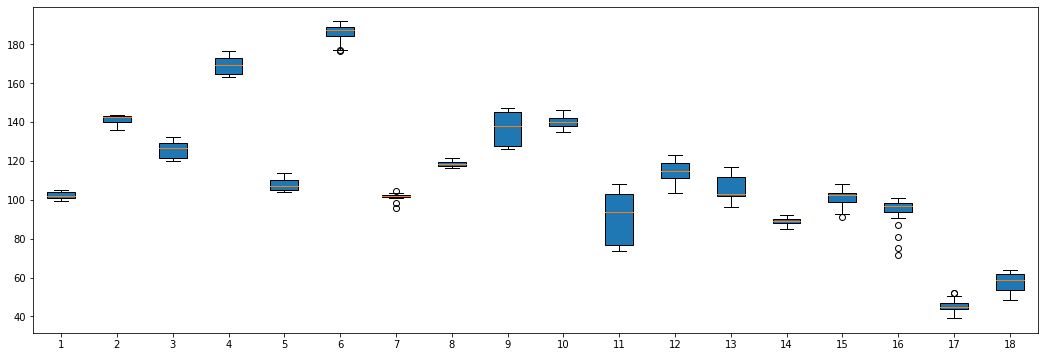

In [52]:
fig = plt.figure(1, figsize=(18, 6))
ax = fig.add_subplot(111)
# Create the boxplot



bp = ax.boxplot(x=list(chunks(all_surfaces_ok,9))[0]+list(chunks(all_surfaces_non,9))[0], 
                #usermedians = [liste1[0], liste2[0],liste3[0], liste4[0],liste5[0], liste6[0],mauvais1[0], mauvais2[0],mauvais3[0], mauvais4[0],mauvais5[0], mauvais6[0]], 
                patch_artist=True
               )


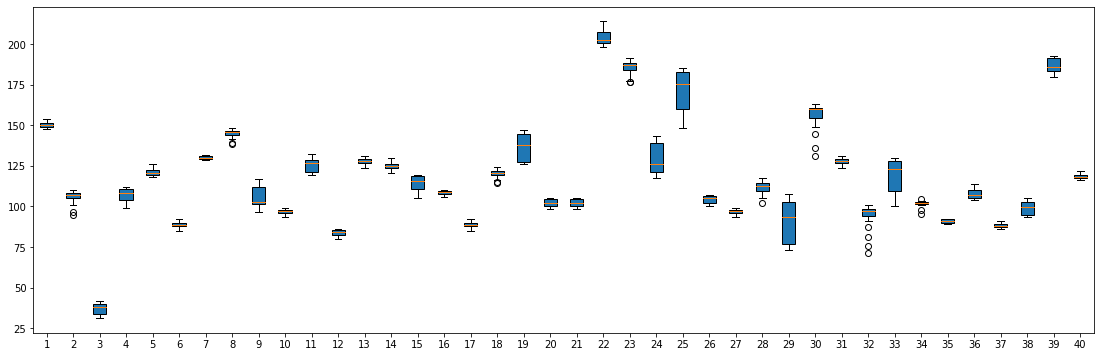

In [34]:
fig = plt.figure(1, figsize=(19, 6))
ax = fig.add_subplot(111)
# Create the boxplot



bp = ax.boxplot(x=all_surfarces_divided[0]+all_surfarces_divided2[0]+all_surfarces_divided3[0], 
                #usermedians = [liste1[0], liste2[0],liste3[0], liste4[0],liste5[0], liste6[0],mauvais1[0], mauvais2[0],mauvais3[0], mauvais4[0],mauvais5[0], mauvais6[0]], 
                patch_artist=True
               )



In [107]:
_,_,liste1,epaisseur1 = testingvol(r"1000189E_243836885220416031580367474191.npy")
_,_,liste2,epaisseur2 = testingvol(r"10000756_852204160315803674557434198400.npy")
_,_,liste3,epaisseur3 = testingvol(r"100009E8_852204160315803674557434202496.npy")
_,_,liste4,epaisseur4 = testingvol(r"10000B6F_243836885220416031580367455411.npy")
_,_,liste5,epaisseur5 = testingvol(r"100009E8_852204160315803674557434202496.npy")
_,_,liste6,epaisseur6 = testingvol(r"10002BDF_243836885220416031580367439564.npy")

_,_,mauvais1,epaisseur_1 = testingvol(r"100003A8_243836885220418191580108063898.npy")
_,_,mauvais2,epaisseur_2 = testingvol(r"100002B2_243836885220418191580108062630.npy")
_,_,mauvais3,epaisseur_3 = testingvol(r"100072D0_396886535464887032575881745524.npy")
_,_,mauvais4,epaisseur_4 = testingvol(r"10006B8D_278210873405123169558773136488.npy")
_,_,mauvais5,epaisseur_5 = testingvol(r"100058AC_924383688522041603158036742433.npy")
_,_,mauvais6,epaisseur_6 = testingvol(r"10005E3D_243836885220416031580367424395.npy")

20/20 [==============================] - 3s 170ms/sample


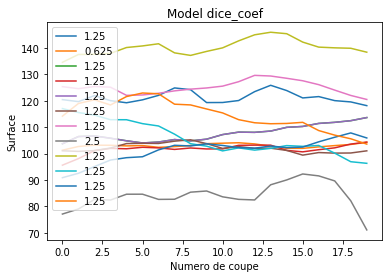

In [108]:
plt.plot(liste1)
plt.plot(liste2)
plt.plot(liste3)
plt.plot(liste4)
plt.plot(liste5)
plt.plot(liste6)
plt.plot(mauvais1)
plt.plot(mauvais2)
plt.plot(mauvais3)
plt.plot(mauvais4)
plt.plot(mauvais5)
plt.plot(mauvais6)
plt.title('Model dice_coef')
plt.ylabel('Surface')
plt.xlabel('Numero de coupe')
plt.legend([epaisseur1, epaisseur2,epaisseur3, epaisseur4,epaisseur5, epaisseur6,epaisseur_1, epaisseur_2,epaisseur_3, epaisseur_4,epaisseur_5, epaisseur_6], loc='upper left')
plt.show()

In [113]:
print(len(liste5))

20


<h1> Compte du nb de scanners </h1>

In [9]:
liste = fast_scandir(r"J:\ExportODIASP3")

volumes = 0
images = 0

for dossier in liste :
    nbitem = len(os.listdir(dossier))
    if nbitem >70 : 
        volumes +=1
        images += nbitem

print(len(liste))
print(volumes)
print(images)

613
123
84783
